In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import shutil
import torch
import time
import matplotlib.pyplot as plt
%matplotlib inline
from torch import Tensor
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as tt
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset, Subset
from tempfile import TemporaryDirectory
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [ ]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def all_scores(labels, preds):
    report = classification_report(labels, preds, digits=3, output_dict=True, zero_division=0)
    acc_sc = balanced_accuracy_score(labels, preds)
    f1_sc = report['macro avg']['f1-score']
    recall_sc = report['macro avg']['recall']
    precision_sc = report['macro avg']['precision']
    return acc_sc, f1_sc, recall_sc, precision_sc

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def auc_roc_sc(labels, probs):
    pred_soft = [softmax(x) for x in probs]
    return roc_auc_score(labels, pred_soft, average='macro', multi_class='ovr')

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/fer_ckplus.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_test.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_train.zip'

In [ ]:
valid_size = 700

data_transforms = {
    'train': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.RandomHorizontalFlip(),
                        tt.RandomRotation(30),
                        tt.ToTensor()]),
    'val': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.ToTensor()]),
}

train_data = ConcatDataset([ImageFolder('/content/rafdb_train', data_transforms['train']),
                            ImageFolder('/content/fer_ckplus', data_transforms['train'])])
val_data = ConcatDataset([ImageFolder('/content/rafdb_train', data_transforms['val']),
                            ImageFolder('/content/fer_ckplus', data_transforms['val'])])

train_indices, val_indices, _, _ = train_test_split(
    range(len(train_data)),
    train_data.datasets[0].targets + train_data.datasets[1].targets,
    stratify=train_data.datasets[0].targets + train_data.datasets[1].targets,
    test_size=valid_size,
)

train_split = Subset(train_data, train_indices)
val_split = Subset(val_data, val_indices)
image_datasets = {
    'train': train_split,
    'val': val_split
    }

batch_size = 64
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=2)
            for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# source for training funtion https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model
def train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=20, patience=10):
    since = time.time()
    results = {'acc': [], 'f1': [], 'rec': [], 'prec': [], 'roc': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        early_stopping = EarlyStopping(patience=patience, verbose=False)
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                    pred_list = []
                    label_list = []
                    output_list = []

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], leave=False, desc=phase):
                    if phase == 'val':
                        label_list = label_list + labels.tolist()

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'val':
                            output_list = output_list + outputs.tolist()
                            pred_list = pred_list + preds.tolist()

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            if grad_clip:
                                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                            optimizer.step()
                            scheduler.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    train_loss = running_loss / dataset_sizes[phase]
                if phase == 'val':
                    val_loss = running_loss / dataset_sizes[phase]
                    acc, f1, prec, rec = all_scores(label_list, pred_list)
                    roc = auc_roc_sc(label_list, output_list)

                    results['acc'].append(acc)
                    results['f1'].append(f1)
                    results['prec'].append(prec)
                    results['rec'].append(rec)
                    results['roc'].append(roc)

                    if epoch < 10:
                        s = '0'
                    else:
                        s = ''

                    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                        s+str(epoch), get_lr(optimizer), train_loss, val_loss, acc))

                # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and acc > best_acc:
                    best_acc = acc
                    torch.save(model.state_dict(), best_model_params_path)

                    early_stopping(val_loss, model)

                    if early_stopping.early_stop:
                        print("Early stopping")
                        break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, results

In [ ]:
from torchvision.ops.misc import Conv2dNormActivation, Permute
from torchvision.ops.stochastic_depth import StochasticDepth
from typing import Any, Callable, Dict, List, Optional, Sequence, Tuple, Union
import copy
import math
from torchvision.models.mobilenetv3 import InvertedResidualConfig, InvertedResidual
from functools import partial

In [ ]:
# https://pytorch.org/vision/stable/_modules/torchvision/models/mobilenetv3.html
class MobileNetV3(nn.Module):
    def __init__(
        self,
        inverted_residual_setting: List[InvertedResidualConfig],
        last_channel: int,
        num_classes: int = 7,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        dropout: float = 0.2,
        **kwargs: Any,
    ) -> None:
        super().__init__()
        # _log_api_usage_once(self)

        if not inverted_residual_setting:
            raise ValueError("The inverted_residual_setting should not be empty")
        elif not (
            isinstance(inverted_residual_setting, Sequence)
            and all([isinstance(s, InvertedResidualConfig) for s in inverted_residual_setting])
        ):
            raise TypeError("The inverted_residual_setting should be List[InvertedResidualConfig]")

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = partial(nn.BatchNorm2d, eps=0.001, momentum=0.01)

        layers: List[nn.Module] = []

        # building first layer
        firstconv_output_channels = inverted_residual_setting[0].input_channels
        layers.append(
            Conv2dNormActivation(
                1,
                firstconv_output_channels,
                kernel_size=3,
                stride=2,
                norm_layer=norm_layer,
                activation_layer=nn.Hardswish,
            )
        )

        # building inverted residual blocks
        for cnf in inverted_residual_setting:
            layers.append(block(cnf, norm_layer))

        # building last several layers
        lastconv_input_channels = inverted_residual_setting[-1].out_channels
        lastconv_output_channels = 6 * lastconv_input_channels
        layers.append(
            Conv2dNormActivation(
                lastconv_input_channels,
                lastconv_output_channels,
                kernel_size=1,
                norm_layer=norm_layer,
                activation_layer=nn.Hardswish,
            )
        )

        self.features = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(lastconv_output_channels, last_channel),
            nn.Hardswish(inplace=True),
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(last_channel, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.features(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.classifier(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [ ]:
reduce_divider = 1
dilation = 1
width_mult = 1.0

bneck_conf = partial(InvertedResidualConfig, width_mult=width_mult)
adjust_channels = partial(InvertedResidualConfig.adjust_channels, width_mult=width_mult)
inverted_residual_setting = [
            bneck_conf(16, 3, 16, 16, False, "RE", 1, 1),
            bneck_conf(16, 3, 64, 24, False, "RE", 2, 1),  # C1
            bneck_conf(24, 3, 72, 24, False, "RE", 1, 1),
            bneck_conf(24, 5, 72, 40, True, "RE", 2, 1),  # C2
            bneck_conf(40, 5, 120, 40, True, "RE", 1, 1),
            bneck_conf(40, 5, 120, 40, True, "RE", 1, 1),
            bneck_conf(40, 3, 240, 80, False, "HS", 2, 1),  # C3
            bneck_conf(80, 3, 200, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 184, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 184, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 480, 112, True, "HS", 1, 1),
            bneck_conf(112, 3, 672, 112, True, "HS", 1, 1),
            bneck_conf(112, 5, 672, 160 // reduce_divider, True, "HS", 2, dilation),  # C4
            bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, dilation),
            bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, dilation),
        ]
last_channel = adjust_channels(1280 // reduce_divider)  # C5

model = MobileNetV3(inverted_residual_setting, last_channel)

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
max_lr = 0.001
epochs = 70
grad_clip = 0.2
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(dataloaders['train']))

In [ ]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             144
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         Hardswish-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]             144
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]             256
       BatchNorm2d-8           [-1, 16, 32, 32]              32
  InvertedResidual-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]           1,024
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]             576
      BatchNorm2d-14           [-1, 64,

In [ ]:
model, results =  train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=epochs, patience=4)

train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [00], last_lr: 0.00005, train_loss: 1.7873, val_loss: 1.7944, val_acc: 0.1429


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [01], last_lr: 0.00006, train_loss: 1.7493, val_loss: 1.7358, val_acc: 0.1788


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [02], last_lr: 0.00009, train_loss: 1.6781, val_loss: 1.6520, val_acc: 0.2543


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [03], last_lr: 0.00012, train_loss: 1.5870, val_loss: 1.5537, val_acc: 0.2852


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [04], last_lr: 0.00017, train_loss: 1.5074, val_loss: 1.4791, val_acc: 0.3180


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [05], last_lr: 0.00022, train_loss: 1.4307, val_loss: 1.3927, val_acc: 0.3589


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [06], last_lr: 0.00028, train_loss: 1.3547, val_loss: 1.3320, val_acc: 0.3695


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [07], last_lr: 0.00034, train_loss: 1.2950, val_loss: 1.2652, val_acc: 0.4042


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [08], last_lr: 0.00041, train_loss: 1.2439, val_loss: 1.2010, val_acc: 0.4125


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [09], last_lr: 0.00048, train_loss: 1.2023, val_loss: 1.2594, val_acc: 0.4226
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00056, train_loss: 1.1624, val_loss: 1.1705, val_acc: 0.4586


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00063, train_loss: 1.1317, val_loss: 1.1639, val_acc: 0.4578


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00070, train_loss: 1.1052, val_loss: 1.2402, val_acc: 0.4061


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00076, train_loss: 1.0780, val_loss: 1.1336, val_acc: 0.4405


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00082, train_loss: 1.0597, val_loss: 1.1700, val_acc: 0.4559


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00087, train_loss: 1.0456, val_loss: 1.1402, val_acc: 0.4847


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00092, train_loss: 1.0272, val_loss: 1.0869, val_acc: 0.4549


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00095, train_loss: 1.0092, val_loss: 1.0069, val_acc: 0.4983


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00098, train_loss: 0.9923, val_loss: 1.0362, val_acc: 0.5035
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00099, train_loss: 0.9753, val_loss: 1.1267, val_acc: 0.4808


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00100, train_loss: 0.9669, val_loss: 1.0369, val_acc: 0.5042
EarlyStopping counter: 2 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00100, train_loss: 0.9521, val_loss: 1.0212, val_acc: 0.5086
EarlyStopping counter: 3 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00100, train_loss: 0.9369, val_loss: 0.9802, val_acc: 0.5515


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00099, train_loss: 0.9243, val_loss: 1.0365, val_acc: 0.4992


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00098, train_loss: 0.9178, val_loss: 1.0434, val_acc: 0.5163


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00097, train_loss: 0.9002, val_loss: 0.9681, val_acc: 0.5253


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00096, train_loss: 0.8897, val_loss: 0.9593, val_acc: 0.5602


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00095, train_loss: 0.8788, val_loss: 0.9249, val_acc: 0.5487


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00094, train_loss: 0.8718, val_loss: 0.9474, val_acc: 0.5213


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00092, train_loss: 0.8611, val_loss: 0.9572, val_acc: 0.5491


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [30], last_lr: 0.00090, train_loss: 0.8482, val_loss: 0.9333, val_acc: 0.5347


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [31], last_lr: 0.00088, train_loss: 0.8427, val_loss: 0.9651, val_acc: 0.5358


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [32], last_lr: 0.00086, train_loss: 0.8290, val_loss: 0.9258, val_acc: 0.5423


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [33], last_lr: 0.00084, train_loss: 0.8197, val_loss: 1.0003, val_acc: 0.5308


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [34], last_lr: 0.00081, train_loss: 0.8176, val_loss: 0.9389, val_acc: 0.5383


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [35], last_lr: 0.00079, train_loss: 0.8036, val_loss: 0.9266, val_acc: 0.5555


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [36], last_lr: 0.00076, train_loss: 0.7926, val_loss: 0.9217, val_acc: 0.5696


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [37], last_lr: 0.00073, train_loss: 0.7866, val_loss: 0.9174, val_acc: 0.5655


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [38], last_lr: 0.00070, train_loss: 0.7752, val_loss: 0.9056, val_acc: 0.5577


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [39], last_lr: 0.00067, train_loss: 0.7741, val_loss: 0.9545, val_acc: 0.5772
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [40], last_lr: 0.00064, train_loss: 0.7564, val_loss: 0.8792, val_acc: 0.5947


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [41], last_lr: 0.00061, train_loss: 0.7494, val_loss: 0.8924, val_acc: 0.5766


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [42], last_lr: 0.00058, train_loss: 0.7371, val_loss: 0.8804, val_acc: 0.5787


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [43], last_lr: 0.00055, train_loss: 0.7328, val_loss: 0.9082, val_acc: 0.6043
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [44], last_lr: 0.00052, train_loss: 0.7224, val_loss: 0.8842, val_acc: 0.6117
EarlyStopping counter: 2 out of 4


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [45], last_lr: 0.00048, train_loss: 0.7134, val_loss: 0.8488, val_acc: 0.6149


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [46], last_lr: 0.00045, train_loss: 0.6994, val_loss: 0.8290, val_acc: 0.6033


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [47], last_lr: 0.00042, train_loss: 0.6951, val_loss: 0.8424, val_acc: 0.6100


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [48], last_lr: 0.00039, train_loss: 0.6834, val_loss: 0.8907, val_acc: 0.5901


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [49], last_lr: 0.00036, train_loss: 0.6723, val_loss: 0.8467, val_acc: 0.6396


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [50], last_lr: 0.00033, train_loss: 0.6616, val_loss: 0.8817, val_acc: 0.6185


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [51], last_lr: 0.00030, train_loss: 0.6501, val_loss: 0.8337, val_acc: 0.6078


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [52], last_lr: 0.00027, train_loss: 0.6391, val_loss: 0.8208, val_acc: 0.6436


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [53], last_lr: 0.00024, train_loss: 0.6284, val_loss: 0.8466, val_acc: 0.5955


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [54], last_lr: 0.00021, train_loss: 0.6205, val_loss: 0.8530, val_acc: 0.6215


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [55], last_lr: 0.00019, train_loss: 0.6068, val_loss: 0.8391, val_acc: 0.6189


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [56], last_lr: 0.00016, train_loss: 0.6077, val_loss: 0.8672, val_acc: 0.6419


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [57], last_lr: 0.00014, train_loss: 0.5923, val_loss: 0.8232, val_acc: 0.6162


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [58], last_lr: 0.00012, train_loss: 0.5883, val_loss: 0.8166, val_acc: 0.6498


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [59], last_lr: 0.00010, train_loss: 0.5782, val_loss: 0.7953, val_acc: 0.6248


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [60], last_lr: 0.00008, train_loss: 0.5704, val_loss: 0.8473, val_acc: 0.6271


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [61], last_lr: 0.00006, train_loss: 0.5669, val_loss: 0.8651, val_acc: 0.6332


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [62], last_lr: 0.00005, train_loss: 0.5614, val_loss: 0.8407, val_acc: 0.6306


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [63], last_lr: 0.00004, train_loss: 0.5535, val_loss: 0.8600, val_acc: 0.6232


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [64], last_lr: 0.00003, train_loss: 0.5525, val_loss: 0.8328, val_acc: 0.6313


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [65], last_lr: 0.00002, train_loss: 0.5500, val_loss: 0.8236, val_acc: 0.6281


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [66], last_lr: 0.00001, train_loss: 0.5447, val_loss: 0.7922, val_acc: 0.6487


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [67], last_lr: 0.00000, train_loss: 0.5445, val_loss: 0.8263, val_acc: 0.6366


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [68], last_lr: 0.00000, train_loss: 0.5398, val_loss: 0.8222, val_acc: 0.6303


train:   0%|          | 0/685 [00:00<?, ?it/s]

val:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch [69], last_lr: 0.00000, train_loss: 0.5425, val_loss: 0.8497, val_acc: 0.6384
Training complete in 74m 56s
Best val Acc: 0.649823


In [ ]:
kdef_ds = ImageFolder('/content/kdef', data_transforms['val'])
kdef_test_dl = DataLoader(kdef_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.5918 , roc: 0.9188 , f1: 0.5574 , recall: 0.7131


In [ ]:
test_raf_ds = ImageFolder('/content/rafdb_test', data_transforms['val'])
test_raf_dl = DataLoader(test_raf_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(test_raf_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/48 [00:00<?, ?it/s]

acc: 0.6779 , roc: 0.9519 , f1: 0.6842 , recall: 0.6947


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/msc_thesis/notebooks/mobilenetraf.pt')

In [ ]:
results = {'acc': [0.14285714285714285, 0.17878811124685232, 0.2543115584832339, 0.28515806414728456, 0.3180215466145408, 0.35889323994315714, 0.369493881702171, 0.4041523689347969, 0.41247928924437394, 0.4226138743368915, 0.45856464751463444, 0.45784105625315225, 0.4060571235229852, 0.4404906740090548, 0.45594685402466206, 0.4846683443726517, 0.4548986192855788, 0.4982643582643452, 0.5034831004748659, 0.48075024336194944, 0.5041785522966021, 0.5086088901613652, 0.55149162361724, 0.49922849205955905, 0.5163229915323877, 0.5252608422066812, 0.5601783257856644, 0.548741094068716, 0.5213465733854619, 0.5491352850411623, 0.5346672226878543, 0.5358295166022342, 0.5422748247288972, 0.5307694932539754, 0.5382612553849441, 0.5554524045854053, 0.5696371753688786, 0.5654503485209909, 0.5577177000822954, 0.5772261747085945, 0.5946828327541976, 0.5766277064499167, 0.5787333722760872, 0.6042551676217501, 0.6116632645648615, 0.6148855979194955, 0.6033482407897289, 0.6099803009538771, 0.5900778649249155, 0.6395545410831301, 0.6185384606039783, 0.6078110725276197, 0.6435839959123991, 0.5955433988628679, 0.6215426741660688, 0.6189364074734295, 0.6418752406197419, 0.6162149831590809, 0.6498225758346415, 0.6247780007818522, 0.62707654044685, 0.6332329995902357, 0.6306001141147866, 0.6232155733787738, 0.6313023374411236, 0.6281114544210086, 0.6487295891139018, 0.6365731104181117, 0.6303333646123559, 0.6384408184755842], 'f1': [0.06737367436057393, 0.13963048054391874, 0.2178342745703559, 0.24863324976095777, 0.2986593515034825, 0.3490905898462948, 0.3413935226516765, 0.38182412465563925, 0.39020065304200896, 0.41441550347748535, 0.44934010119155, 0.45262202295893567, 0.4062744536172983, 0.4222145126105689, 0.4498836692076925, 0.46894845570464233, 0.4559257420659645, 0.4980893201677777, 0.500043761240757, 0.4612165859531646, 0.520734656704071, 0.5122349378695572, 0.5562843185146497, 0.4926121446721123, 0.509521946582498, 0.5313995713056954, 0.5569905878436895, 0.548281685701679, 0.5308671390524652, 0.5538845418370887, 0.538326360382217, 0.5471688495348949, 0.5442480013809187, 0.5363154489827008, 0.5490202036421864, 0.5655113851556824, 0.5741007941298862, 0.5806290696325532, 0.5632776341521073, 0.5623333341835285, 0.5957890341389044, 0.6007990081846282, 0.5944541461892874, 0.6082718936693692, 0.6175220876337685, 0.6209338437558266, 0.6213248603295243, 0.6156229103638664, 0.5909573830720641, 0.654551866000408, 0.6210446275114363, 0.6173256328016326, 0.6548389371240304, 0.6085699746355464, 0.6348983245420363, 0.6268795198892916, 0.6525472757558474, 0.6245490371112693, 0.650466176416824, 0.6341199103141203, 0.6283084173705706, 0.6321555030647591, 0.6300844203632784, 0.6304776501857452, 0.6333513584804848, 0.6319519283226082, 0.6589942419985609, 0.6457893886897296, 0.6345857042551392, 0.6505444580430711], 'rec': [0.04408163265306122, 0.1594204551180061, 0.23258581342923854, 0.24150047211632436, 0.3416918665719128, 0.36012444580031217, 0.39136696773036156, 0.40390919632060956, 0.3888982249932234, 0.44932407109687655, 0.4798266043874308, 0.47620491797493475, 0.4665845725886297, 0.5099241196236598, 0.5656120614940107, 0.5540432835847243, 0.5077238052792421, 0.5580769138637763, 0.5017740675102739, 0.5358546812925672, 0.592364220142404, 0.5392136069025865, 0.5670828850153669, 0.5236239209951152, 0.5342855050515836, 0.5582978069425767, 0.5810404116595705, 0.5791104236231491, 0.6106405774040928, 0.5834277081638932, 0.6051879602182562, 0.5781280107499134, 0.5942635945020076, 0.5631299566756842, 0.5855769885823195, 0.6228156424634822, 0.5947672224448006, 0.6348010792010493, 0.610835584198402, 0.5655113370492, 0.6152922785188232, 0.6594416585211399, 0.6499590494171049, 0.6349699474592144, 0.628463810380639, 0.6435276755883258, 0.6719852398120649, 0.6265046310341658, 0.5962146750619436, 0.6985592130480417, 0.6298686834401119, 0.6432967287006229, 0.6791079356743476, 0.637313937330821, 0.6586023045958621, 0.6433455721653207, 0.6807805330336439, 0.6456234678079832, 0.6643079004667511, 0.6490813850382068, 0.6331945661196255, 0.6336571480566217, 0.6322624408977405, 0.6477564367011822, 0.6389890826824499, 0.6404178893774978, 0.6767858888585028, 0.6631339708938916, 0.6447571803147893, 0.6784483135452302], 'prec': [0.14285714285714285, 0.17878811124685232, 0.2543115584832339, 0.28515806414728456, 0.3180215466145408, 0.35889323994315714, 0.369493881702171, 0.4041523689347969, 0.41247928924437394, 0.4226138743368915, 0.45856464751463444, 0.45784105625315225, 0.4060571235229852, 0.4404906740090548, 0.45594685402466206, 0.4846683443726517, 0.4548986192855788, 0.4982643582643452, 0.5034831004748659, 0.48075024336194944, 0.5041785522966021, 0.5086088901613652, 0.55149162361724, 0.49922849205955905, 0.5163229915323877, 0.5252608422066812, 0.5601783257856644, 0.548741094068716, 0.5213465733854619, 0.5491352850411623, 0.5346672226878543, 0.5358295166022342, 0.5422748247288972, 0.5307694932539754, 0.5382612553849441, 0.5554524045854053, 0.5696371753688786, 0.5654503485209909, 0.5577177000822954, 0.5772261747085945, 0.5946828327541976, 0.5766277064499167, 0.5787333722760872, 0.6042551676217501, 0.6116632645648615, 0.6148855979194955, 0.6033482407897289, 0.6099803009538771, 0.5900778649249155, 0.6395545410831301, 0.6185384606039783, 0.6078110725276197, 0.6435839959123991, 0.5955433988628679, 0.6215426741660688, 0.6189364074734295, 0.6418752406197419, 0.6162149831590809, 0.6498225758346415, 0.6247780007818522, 0.62707654044685, 0.6332329995902357, 0.6306001141147866, 0.6232155733787738, 0.6313023374411236, 0.6281114544210086, 0.6487295891139018, 0.6365731104181117, 0.6303333646123559, 0.6384408184755842], 'roc': [0.5611094667295723, 0.5889629928059005, 0.6650502023917574, 0.7147079677779654, 0.7478298941672986, 0.785028832976235, 0.8003477363788818, 0.8215653267599972, 0.8450152799563657, 0.8370669389313702, 0.8524743885314063, 0.851764749773788, 0.8359406058920947, 0.8660924802619313, 0.8666376546957919, 0.8682589186329673, 0.8735647782296102, 0.8896842197499308, 0.8877906077314393, 0.8787605277071747, 0.8871848186606472, 0.8905920213027417, 0.8968251094901707, 0.8858967344914078, 0.8908141450764232, 0.9004651537087697, 0.9040865024659581, 0.9090012913700077, 0.9064853408890933, 0.9047811001322751, 0.9087767488875425, 0.9012640049662749, 0.9159948089783888, 0.8971344750194433, 0.9126933601165957, 0.909816868386287, 0.9099056882444608, 0.9040066031207754, 0.9165057205416804, 0.9102853114784624, 0.9204609693154598, 0.9222901166850141, 0.9164946616641497, 0.9169335027220118, 0.918201680891375, 0.9243062464436083, 0.9263760699364114, 0.922850329014928, 0.9173225033743163, 0.92668500425072, 0.9217460394003064, 0.9273081991019525, 0.9307390885430566, 0.9263720617263013, 0.9264320794739709, 0.926842946403453, 0.9234077576546198, 0.9296486447106453, 0.9314245050859381, 0.9336298108184603, 0.9279652823274224, 0.9249566364761437, 0.9286929380457688, 0.9288062131759557, 0.9305421066202293, 0.9326293425591857, 0.9348080433695877, 0.9332054434895943, 0.9335584097983206, 0.9292110814622916]}

In [ ]:
model = MobileNetV3(inverted_residual_setting, last_channel)
model.load_state_dict(torch.load('/content/drive/MyDrive/msc_thesis/notebooks/mobilenetraf.pt'))
model = model.to(device)

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef_faces.zip'
criterion = nn.CrossEntropyLoss()
kdef_f_ds = ImageFolder('/content/kdef_faces', data_transforms['val'])
kdef_f_test_dl = DataLoader(kdef_f_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_f_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

replace kdef_faces/anger/AF01ANS.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.6694 , roc: 0.951 , f1: 0.6503 , recall: 0.7313


In [ ]:
def plot_scores(results):
    plt.figure(figsize=(8, 6), dpi=150)
    epochs = len(results['acc'])
    # plt.plot(results['prec'], color='limegreen', label='precision')
    plt.plot(results['rec'], color='orange', label='recall')
    plt.plot(results['f1'], color='dodgerblue', label='f1-score')
    plt.plot(results['roc'], color = 'blueviolet', label='roc-auc')
    plt.plot(results['acc'], color='red', label='accuracy')
    plt.ylabel('performance scores')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.title('Model performance vs. No. of epochs')
    plt.show()

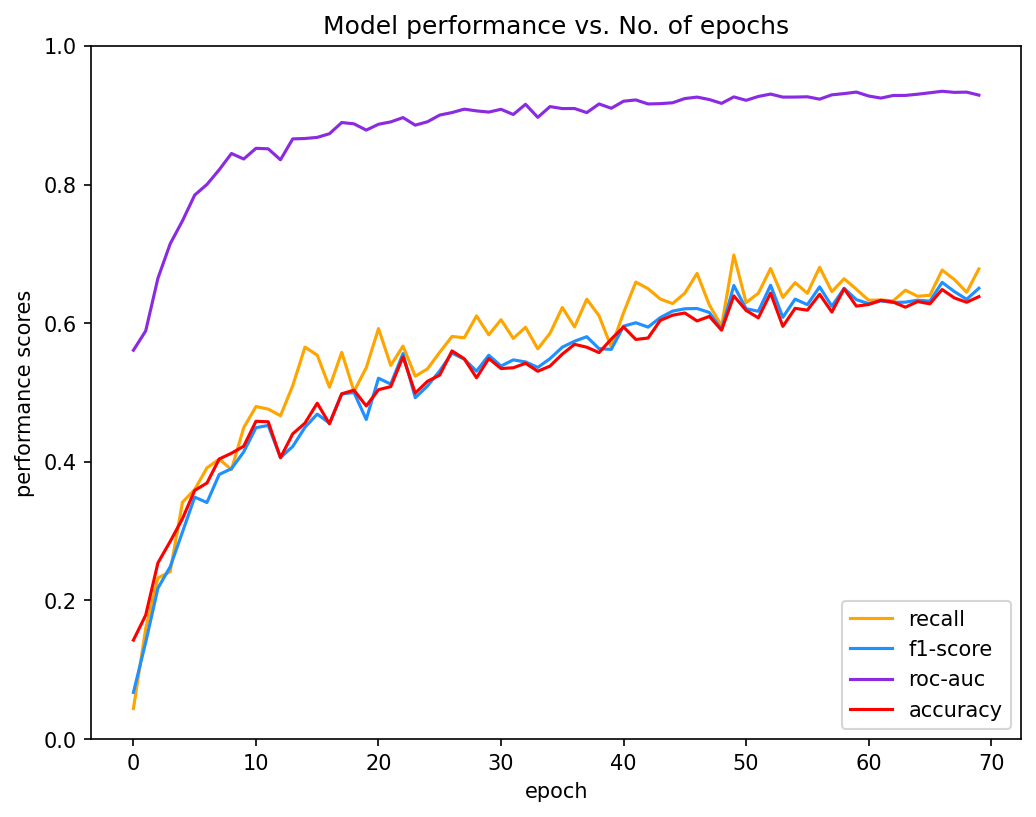

In [ ]:
plot_scores(results)

In [ ]:
#source for timing the model execution: https://deci.ai/blog/measure-inference-time-deep-neural-networks/
dummy_input = torch.randn(1,1,64,64, dtype=torch.float).to(device)

# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 10000
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print("Avg prediction time:", round(mean_syn,3), "Sd:", round(std_syn,3))

Avg prediction time: 8.566 Sd: 1.599
